In [1]:
%matplotlib inline
import os, sys

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib/keras_ex')
#from gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from gkernel.sklearn import (
    RBFRegressor, RBFClassifier,
    make_model_gkernel1,
    make_model_gkernel2,
    make_model_gkernel3,
    make_model_out,
    make_model
)

In [3]:
# from sklearn.datasets import load_digits
# digits = load_digits()
# X, y = digits.data, digits.target
# X = X / 16
# X.shape, X.min(), X.max()

In [4]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [5]:
X, y = mnist.data, mnist.target
X = X / 255
X.shape, X.min(), X.max()

((70000, 784), 0.0, 1.0)

In [6]:
y.shape

(70000,)

In [7]:
y_cat = to_categorical(y, num_classes=10)
y_cat.shape

(70000, 10)

In [8]:
(
    x_train, x_test,
    y_cat_train, y_cat_test,
    y_train, y_test
) = train_test_split(X, y_cat, y,
                     test_size=0.4,
                     stratify=y, random_state=10002)

(
    x_train.shape, x_test.shape,
    y_cat_train.shape, y_cat_test.shape,
    y_train.shape, y_test.shape
)

((42000, 784), (28000, 784), (42000, 10), (28000, 10), (42000,), (28000,))

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, Lasso
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import joblib

from lightgbm import LGBMClassifier

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
def f1_scorer(estimator, X, y):
    pred = estimator.predict(X)
    s = f1_score(y, pred, average='macro')
    return s

## clf1

In [12]:
clf1 = RBFClassifier(
    num_lm=150,
    lm_select_from_x=True,
    random_state=10001,
    #make_model_gkernel=make_model_gkernel3,
    #tol=float(np.sqrt(np.finfo(np.float32).eps)/2),
    lr=0.05, gamma='scale',
    epochs=50, batch_size=500, verbose=0,
    session_clear=False
)
# clf1 = LGBMClassifier(min_child_samples=50, reg_alpha=0.1)

In [13]:
%%time
#hst = clf1.fit(x_train, y_cat_train)
hst = clf1.fit(x_train, y_train)

W1002 23:13:02.071916 140116843501376 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1002 23:13:02.086675 140116843501376 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1002 23:13:02.094478 140116843501376 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1002 23:13:02.095262 140116843501376 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. P

CPU times: user 2min 31s, sys: 3.06 s, total: 2min 34s
Wall time: 1min 26s


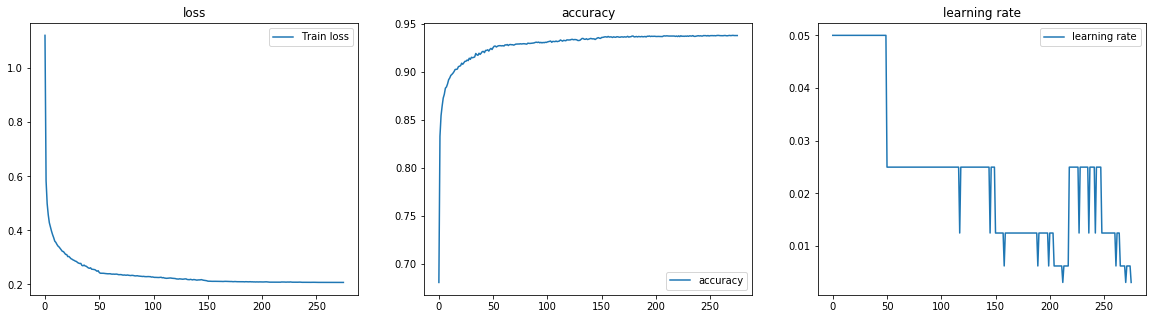

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [15]:
pred = clf1.predict(x_train)
pred.shape

(42000,)

In [16]:
pred

array([2., 9., 9., ..., 8., 4., 1.])

In [17]:
print('F1_SCORE :', f1_score(y_train, pred, average='macro'))
print(classification_report(y_train, pred))
print(confusion_matrix(y_train, pred))

F1_SCORE : 0.9366277813701945
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      4142
         1.0       0.97      0.97      0.97      4726
         2.0       0.93      0.93      0.93      4194
         3.0       0.93      0.91      0.92      4285
         4.0       0.92      0.94      0.93      4094
         5.0       0.92      0.91      0.92      3788
         6.0       0.96      0.96      0.96      4125
         7.0       0.94      0.94      0.94      4376
         8.0       0.92      0.91      0.91      4095
         9.0       0.91      0.90      0.91      4175

   micro avg       0.94      0.94      0.94     42000
   macro avg       0.94      0.94      0.94     42000
weighted avg       0.94      0.94      0.94     42000

[[4045    0   10    3    8   26   21    8   17    4]
 [   1 4607   23   12    8   12    6   13   38    6]
 [  19   21 3888   45   54   15   26   55   61   10]
 [   7   15   85 3918    5  107    9   38   67   34]

In [18]:
pred_test = clf1.predict(x_test)
pred_test.shape

(28000,)

In [19]:
print('F1_SCORE :', f1_score(y_test, pred_test, average='macro'))
print(classification_report(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))

F1_SCORE : 0.9334458897793754
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2761
         1.0       0.97      0.98      0.97      3151
         2.0       0.93      0.92      0.92      2796
         3.0       0.92      0.91      0.92      2856
         4.0       0.91      0.94      0.93      2730
         5.0       0.91      0.91      0.91      2525
         6.0       0.95      0.96      0.96      2751
         7.0       0.95      0.94      0.94      2917
         8.0       0.92      0.91      0.91      2730
         9.0       0.91      0.90      0.91      2783

   micro avg       0.93      0.93      0.93     28000
   macro avg       0.93      0.93      0.93     28000
weighted avg       0.93      0.93      0.93     28000

[[2693    0    9    2    0   18   17    2   15    5]
 [   1 3076   11   13    2   12    4    5   18    9]
 [  16   15 2569   30   48    7   21   22   62    6]
 [   2    3   51 2605    1   92    7   29   44   22]

## clf2

In [20]:
clf2 = RBFClassifier(
    num_lm=150,
    lm_select_from_x=True,
    random_state=10002,
    #make_model_gkernel=make_model_gkernel3,
    #tol=float(np.sqrt(np.finfo(np.float32).eps)/2),
    lr=0.05, gamma='scale',
    epochs=50, batch_size=500, verbose=0,
    session_clear=False
)
# clf2 = LGBMClassifier(min_child_samples=50, reg_alpha=0.1)

In [21]:
%%time
#hst = clf2.fit(x_train, y_cat_train)
hst = clf2.fit(x_train, y_train)

CPU times: user 2min 29s, sys: 2.67 s, total: 2min 31s
Wall time: 1min 24s


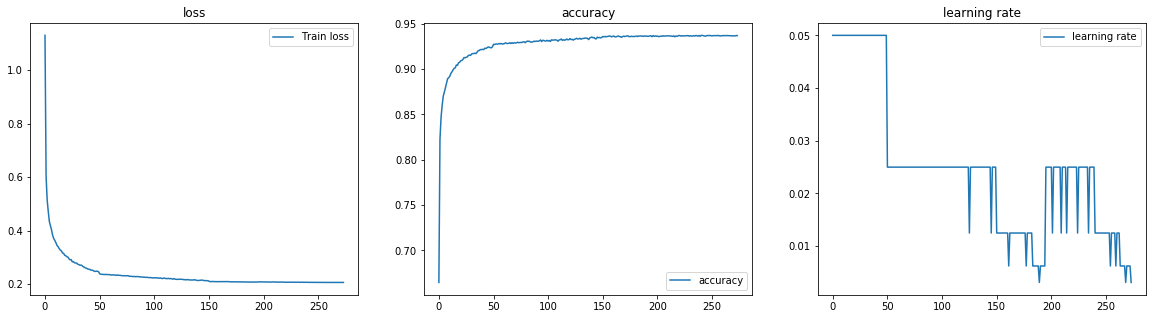

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [23]:
pred = clf2.predict(x_train)
pred.shape

(42000,)

In [24]:
pred

array([2., 9., 9., ..., 8., 4., 1.])

In [25]:
print('F1_SCORE :', f1_score(y_train, pred, average='macro'))
print(classification_report(y_train, pred))
print(confusion_matrix(y_train, pred))

F1_SCORE : 0.9362934672411674
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      4142
         1.0       0.97      0.98      0.97      4726
         2.0       0.93      0.92      0.93      4194
         3.0       0.92      0.91      0.92      4285
         4.0       0.92      0.94      0.93      4094
         5.0       0.92      0.92      0.92      3788
         6.0       0.95      0.97      0.96      4125
         7.0       0.94      0.94      0.94      4376
         8.0       0.93      0.91      0.92      4095
         9.0       0.92      0.90      0.91      4175

   micro avg       0.94      0.94      0.94     42000
   macro avg       0.94      0.94      0.94     42000
weighted avg       0.94      0.94      0.94     42000

[[4040    0   13    6    8   18   22   11   22    2]
 [   0 4616   24   12    9   10    4   14   32    5]
 [  21   22 3879   51   54   20   35   50   50   12]
 [   5   17   83 3902    2  130    8   38   69   31]

In [26]:
pred_test = clf2.predict(x_test)
pred_test.shape

(28000,)

In [27]:
print('F1_SCORE :', f1_score(y_test, pred_test, average='macro'))
print(classification_report(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))

F1_SCORE : 0.9330728939918842
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2761
         1.0       0.97      0.98      0.98      3151
         2.0       0.92      0.92      0.92      2796
         3.0       0.92      0.91      0.92      2856
         4.0       0.92      0.93      0.92      2730
         5.0       0.92      0.92      0.92      2525
         6.0       0.95      0.96      0.96      2751
         7.0       0.94      0.93      0.94      2917
         8.0       0.91      0.91      0.91      2730
         9.0       0.91      0.90      0.90      2783

   micro avg       0.93      0.93      0.93     28000
   macro avg       0.93      0.93      0.93     28000
weighted avg       0.93      0.93      0.93     28000

[[2703    0   12    1    1   10   14    5   14    1]
 [   1 3081   15   11    1    7    2    5   19    9]
 [   9   12 2577   33   47    6   28   21   60    3]
 [   7    4   44 2598    0   93    9   27   51   23]

## clf3

In [28]:
clf3 = RBFClassifier(
    num_lm=150,
    lm_select_from_x=True,
    random_state=10003,
    #make_model_gkernel=make_model_gkernel3,
    #tol=float(np.sqrt(np.finfo(np.float32).eps)/2),
    lr=0.05, gamma='scale',
    epochs=50, batch_size=500, verbose=0,
    session_clear=False
)
# clf3 = LGBMClassifier(min_child_samples=50, reg_alpha=0.1)

In [29]:
%%time
#hst = clf3.fit(x_train, y_cat_train)
hst = clf3.fit(x_train, y_train)

CPU times: user 2min 43s, sys: 2.43 s, total: 2min 45s
Wall time: 1min 28s


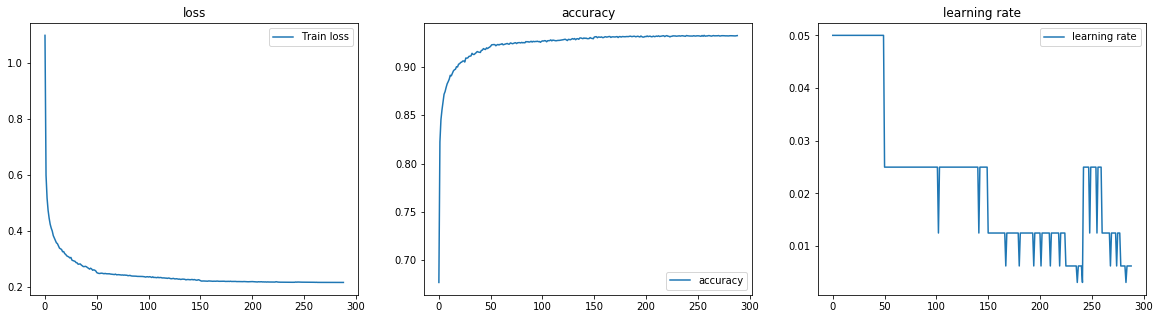

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [31]:
pred = clf3.predict(x_train)
pred.shape

(42000,)

In [32]:
pred

array([2., 9., 9., ..., 8., 4., 1.])

In [33]:
print('F1_SCORE :', f1_score(y_train, pred, average='macro'))
print(classification_report(y_train, pred))
print(confusion_matrix(y_train, pred))

F1_SCORE : 0.9312458482868446
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      4142
         1.0       0.96      0.98      0.97      4726
         2.0       0.93      0.91      0.92      4194
         3.0       0.92      0.92      0.92      4285
         4.0       0.92      0.94      0.93      4094
         5.0       0.90      0.91      0.91      3788
         6.0       0.95      0.96      0.95      4125
         7.0       0.94      0.93      0.93      4376
         8.0       0.91      0.90      0.91      4095
         9.0       0.91      0.90      0.90      4175

   micro avg       0.93      0.93      0.93     42000
   macro avg       0.93      0.93      0.93     42000
weighted avg       0.93      0.93      0.93     42000

[[4031    1    8    7    5   28   25    7   19   11]
 [   0 4610   22   12    8   20    3   15   31    5]
 [  21   26 3830   52   55   15   47   59   76   13]
 [   8   22   75 3922    4  112    8   32   75   27]

In [34]:
pred_test = clf3.predict(x_test)
pred_test.shape

(28000,)

In [35]:
print('F1_SCORE :', f1_score(y_test, pred_test, average='macro'))
print(classification_report(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))

F1_SCORE : 0.9305701140303784
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2761
         1.0       0.97      0.98      0.97      3151
         2.0       0.92      0.91      0.92      2796
         3.0       0.93      0.91      0.92      2856
         4.0       0.92      0.93      0.93      2730
         5.0       0.91      0.91      0.91      2525
         6.0       0.95      0.96      0.95      2751
         7.0       0.93      0.93      0.93      2917
         8.0       0.90      0.90      0.90      2730
         9.0       0.91      0.90      0.90      2783

   micro avg       0.93      0.93      0.93     28000
   macro avg       0.93      0.93      0.93     28000
weighted avg       0.93      0.93      0.93     28000

[[2692    0    7    2    1   20   14    3   13    9]
 [   1 3079   10   13    3   13    4    5   17    6]
 [   7   14 2556   31   37   11   38   30   68    4]
 [   6    7   49 2595    0   76    8   30   60   25]

In [36]:
clfs = [clf1, clf2, clf3]

In [37]:
pred_proba = [clf.predict_proba(x_train) for clf in clfs]

In [38]:
np.stack(pred_proba).mean(axis=0).shape

(42000, 10)

In [39]:
print('F1_SCORE :', f1_score(y_train, np.argmax(np.stack(pred_proba).mean(axis=0), axis=1), average='macro'))
print(classification_report(y_train, np.argmax(np.stack(pred_proba).mean(axis=0), axis=1)))
print(confusion_matrix(y_train, np.argmax(np.stack(pred_proba).mean(axis=0), axis=1)))

F1_SCORE : 0.9404567783192732
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      4142
         1.0       0.97      0.98      0.97      4726
         2.0       0.93      0.93      0.93      4194
         3.0       0.93      0.92      0.92      4285
         4.0       0.93      0.95      0.94      4094
         5.0       0.92      0.93      0.92      3788
         6.0       0.95      0.97      0.96      4125
         7.0       0.95      0.94      0.94      4376
         8.0       0.93      0.91      0.92      4095
         9.0       0.92      0.91      0.92      4175

   micro avg       0.94      0.94      0.94     42000
   macro avg       0.94      0.94      0.94     42000
weighted avg       0.94      0.94      0.94     42000

[[4054    0   12    7    6   15   20    8   17    3]
 [   0 4619   20   11    8   15    6   14   28    5]
 [  22   22 3887   41   50   17   34   53   57   11]
 [   7   18   76 3935    5  106    9   34   68   27]

In [40]:
pred_proba_test = [clf.predict_proba(x_test) for clf in clfs]

In [41]:
np.stack(pred_proba_test).mean(axis=0).shape

(28000, 10)

In [42]:
print('F1_SCORE :', f1_score(y_test, np.argmax(np.stack(pred_proba_test).mean(axis=0), axis=1), average='macro'))
print(classification_report(y_test, np.argmax(np.stack(pred_proba_test).mean(axis=0), axis=1)))
print(confusion_matrix(y_test, np.argmax(np.stack(pred_proba_test).mean(axis=0), axis=1)))

F1_SCORE : 0.9388324018699794
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2761
         1.0       0.97      0.98      0.97      3151
         2.0       0.93      0.92      0.93      2796
         3.0       0.93      0.92      0.93      2856
         4.0       0.92      0.94      0.93      2730
         5.0       0.92      0.93      0.92      2525
         6.0       0.95      0.96      0.96      2751
         7.0       0.95      0.94      0.94      2917
         8.0       0.92      0.91      0.92      2730
         9.0       0.92      0.91      0.91      2783

   micro avg       0.94      0.94      0.94     28000
   macro avg       0.94      0.94      0.94     28000
weighted avg       0.94      0.94      0.94     28000

[[2706    1    6    1    0   15   15    3   11    3]
 [   1 3081    9   13    2   11    3    5   18    8]
 [   9   12 2584   27   44    7   25   23   60    5]
 [   4    5   40 2623    1   83    7   27   45   21]